In [1]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from scipy.signal import find_peaks, peak_widths
import astropy.units as u
import numpy as np
import pandas as pd
from collections import defaultdict

[(1140.23944757, 1140.23023757, 1140.24865757, 0., 0., 0., 0, 1.e+20, 0.)
 (1140.25786757, 1140.24865757, 1140.26707757, 0., 0., 0., 0, 1.e+20, 0.)
 (1140.27628757, 1140.26707757, 1140.28549757, 0., 0., 0., 0, 1.e+20, 0.)
 ...
 (1709.87789926, 1709.86868926, 1709.88710926, 0., 0., 0., 0, 1.e+20, 0.)
 (1709.89631925, 1709.88710926, 1709.90552925, 0., 0., 0., 0, 1.e+20, 0.)
 (1709.91473925, 1709.90552925, 1709.92394925, 0., 0., 0., 0, 1.e+20, 0.)]


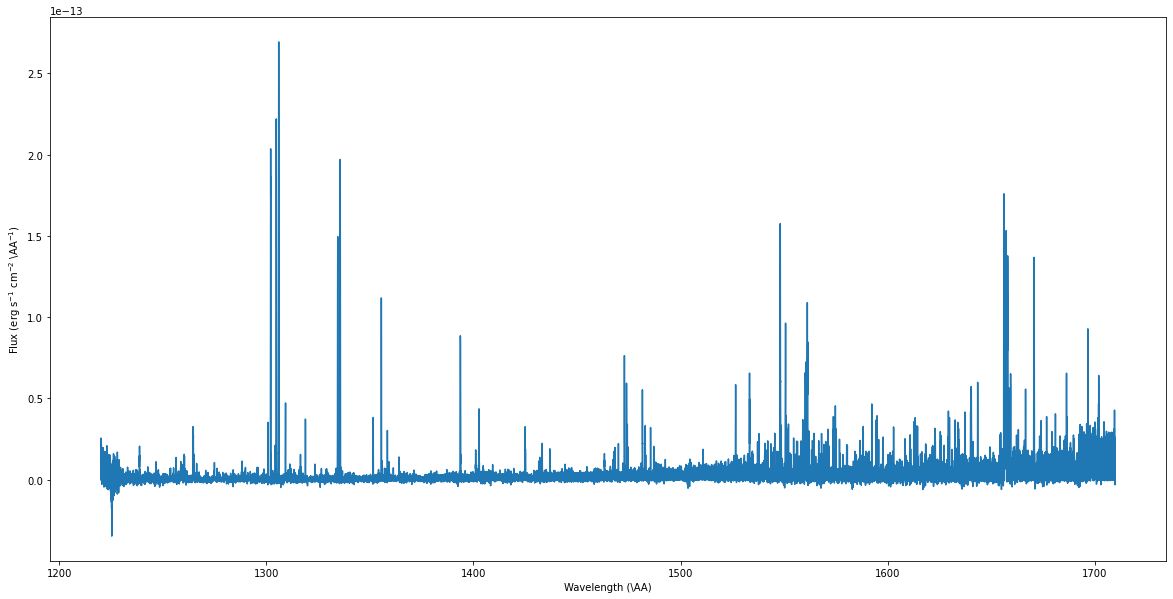

In [2]:
data = fits.getdata('hlsp_muscles_hst_stis_tau_ceti_e140m_v1_component-spec.fits')
print(data)
w, f , e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
mask = w > 1220
plt.figure(figsize=(20,10))
plt.plot(w[mask], f[mask])
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.show()

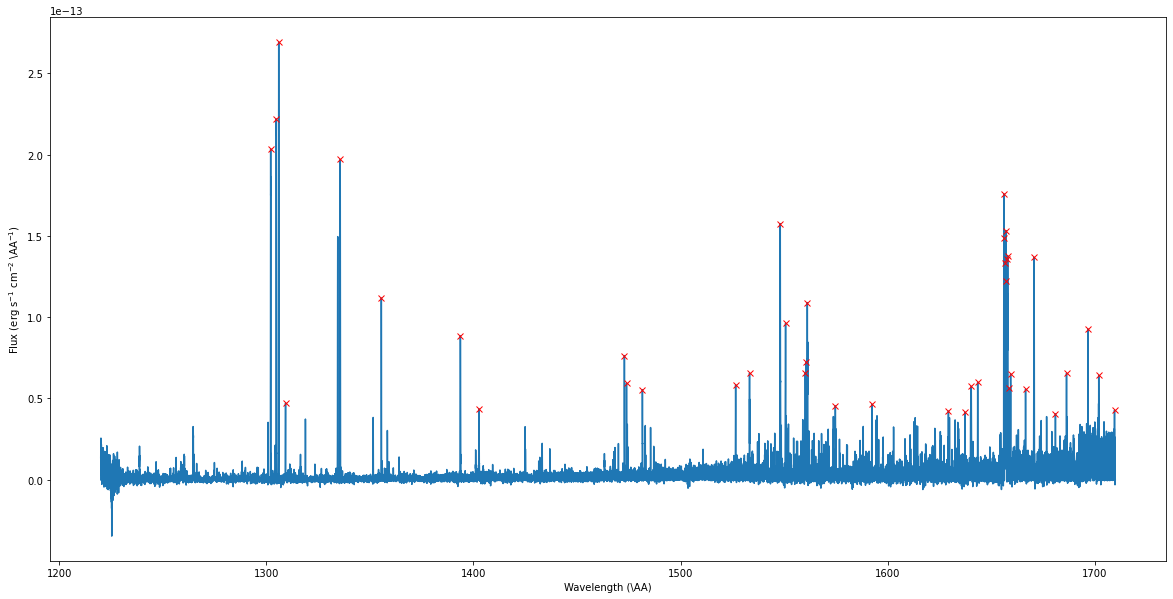

In [3]:
# Find peaks (accurately) and then calculate doppler shift for those peaks 
# ask about me!
peaks, properties  = find_peaks(f[mask], height = 10*sum(f[mask])/len(f[mask]), prominence = 10*sum(f[mask])/len(f[mask]), width = 0, threshold = (1/10)*sum(f[mask])/len(f[mask]))

plt.figure(figsize=(20,10))
plt.plot(w[mask], f[mask])
plt.plot(w[mask][peaks], f[mask][peaks], "xr")
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.show()


# # All peaks!
# count = 0
# for peak in w[mask][peaks]:
#     print(f"Peak {count}: {peak}")
#     count+=1

In [4]:
# Grab data from file
data = pd.read_csv("../DEM_goodlinelist .csv")
df = pd.DataFrame(data)
print(df)

       Ion  Wavelength Likelihood to measure  Log Formation Temperature
0     S VI     933.397                Medium                        5.3
1    N III     989.787                Medium                        4.9
2    N III     991.495                Medium                        4.9
3    N III     991.564                Medium                        4.9
4    Ne VI     999.182                Medium                        5.6
5     O VI    1032.914                Medium                        5.5
6     O VI    1037.615                Medium                        5.5
7   Fe XIX    1118.057                   Low                        6.9
8     Ne V    1145.596                Medium                        5.5
9    C III    1174.935                  High                        4.9
10   C III    1175.265                  High                        4.9
11   C III    1175.592                  High                        4.9
12   C III    1175.713                  High                    

In [9]:
# Find "best" doppler shift (shift the mask consitently!)
rest_lam = []
obs_lam = []
dv = []
rest_lam.append(w[mask][peaks][13] * u.AA)
rest_lam.append(w[mask][peaks][14] * u.AA)
obs_lam.append(1548.201 * u.AA)
obs_lam.append(1550.772 * u.AA)
dv.append(obs_lam[0].to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam[0])))
dv.append(obs_lam[1].to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam[1])))

dv_average = (dv[0] + dv[1])/2
print(f"Avg Doppler Shift: {dv_average}")

Avg Doppler Shift: 12.617351674896131 km / s


[1301.69073388 1301.70915388 1301.72757388 1301.74599387 1301.76441387
 1301.78283387 1301.80125387 1301.81967387 1301.83809387 1301.85651387
 1301.87493386 1301.89335386 1301.91177386 1301.93019386 1301.94861386
 1301.96703386 1301.98545385 1302.00387385 1302.02229385 1302.04071385
 1302.05913385 1302.07755385 1302.09597384 1302.11439384 1302.13281384
 1302.15123384 1302.16965384 1302.18807384 1302.20649384 1302.22491383
 1302.24333383 1302.26175383 1302.28017383 1302.29859383 1302.31701383
 1302.33543382 1302.35385382 1302.37227382 1302.39069382 1302.40911382
 1302.42753382 1302.44595382 1302.46437381]
Flux: 3.571257470632203e-14
Error: 3.6237521599118357e-16


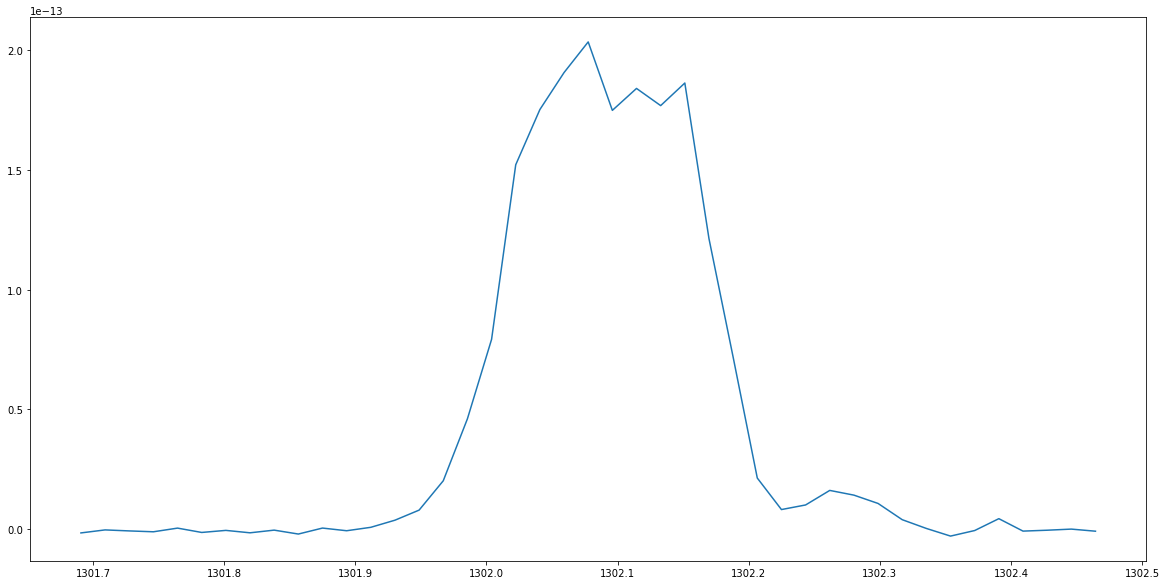

In [6]:
# TEST

def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff0 = np.concatenate((np.array([diff[0]]), diff)) 
    diff1 = np.concatenate((diff, np.array([diff[-1]]))) 
    w0 = w - diff0/2.
    w1 = w + diff1/2.
    return w0, w1


# Mask current peak 
wavelength_mask = (w > (w[mask][peaks][0] - 0.4)) & (w < (w[mask][peaks][0] + 0.4))
print(w[wavelength_mask])
w0,w1 = wavelength_edges(w[wavelength_mask])
total_sumflux = np.sum(f[wavelength_mask]*(w1-w0))
sumerror = (np.sum(e[wavelength_mask]**2 * (w1-w0)**2))**0.5

plt.figure(figsize=(20,10))
plt.plot(w[wavelength_mask], f[wavelength_mask])


# Continuum calculation 
continuum = []

for i in range(0, len(f[wavelength_mask])):
    continuum.append(f[wavelength_mask][0])

continuum_sumflux = np.sum(continuum*(w1-w0))


print(f"Flux: {total_sumflux - continuum_sumflux}")
print(f"Error: {sumerror}")



In [7]:
# initializing
flux = defaultdict(list)
count = 0 

# for wavelengths > mask
for wavelength in df['Wavelength']:
    if(wavelength > 1220):
        continuum = []
        
        # obs_lam calculation from doppler
        rest_lam = wavelength * u.AA
        obs_lam = dv_average.to(u.AA,  equivalencies=u.doppler_optical(rest_lam))
        
        # complete el flux calc
        wavelength_mask = (w > (obs_lam.value - 0.4)) & (w < (obs_lam.value + 0.4))
        w0,w1 = wavelength_edges(w[wavelength_mask])
        total_sumflux = np.sum(f[wavelength_mask]*(w1-w0))
        sumerror = (np.sum(e[wavelength_mask]**2 * (w1-w0)**2))**0.5

        # create a continuum (change?)
        for i in range(0, len(f[wavelength_mask])):
            continuum.append(f[wavelength_mask][0])
        continuum_sumflux = np.sum(continuum*(w1-w0))
        
        # add flux dif and error to dict
        flux[df['Ion'][count]].append(("Wavelength: " + str(wavelength),"Flux: " + str(total_sumflux - continuum_sumflux), "Error: " + str(sumerror))) 
        
    count+=1 
    
# Printing
for ion in flux:
    print(f"Ion: {ion} ")
    print(flux[ion])
        

Ion: N V 
[('Wavelength: 1238.821', 'Flux: 3.3337687708858908e-15', 'Error: 1.4270303248719341e-16'), ('Wavelength: 1242.804', 'Flux: 1.3624512431894669e-15', 'Error: 1.9328313156675626e-16')]
Ion: S II 
[('Wavelength: 1253.811', 'Flux: -7.896911084592507e-16', 'Error: 1.2126777682415794e-16'), ('Wavelength: 1259.519', 'Flux: 8.810947241906984e-16', 'Error: 7.450969324683208e-17')]
Ion: Si II 
[('Wavelength: 1260.417', 'Flux: 2.7497433340287337e-15', 'Error: 1.944756847066647e-16'), ('Wavelength: 1264.737', 'Flux: 7.608760459124282e-15', 'Error: 2.6150628811403475e-16'), ('Wavelength: 1265.001', 'Flux: -1.1793256850420244e-14', 'Error: 2.1084315026657665e-16'), ('Wavelength: 1304.369', 'Flux: 2.8017027891608983e-14', 'Error: 5.198783016348327e-16'), ('Wavelength: 1526.706', 'Flux: 1.0126353220245814e-14', 'Error: 3.192297833263541e-16'), ('Wavelength: 1533.43', 'Flux: 6.7898535473374815e-15', 'Error: 3.4542535231904075e-16')]
Ion: Si III 
[('Wavelength: 1294.543', 'Flux: 1.915697843255

(1540.0, 1560.0)

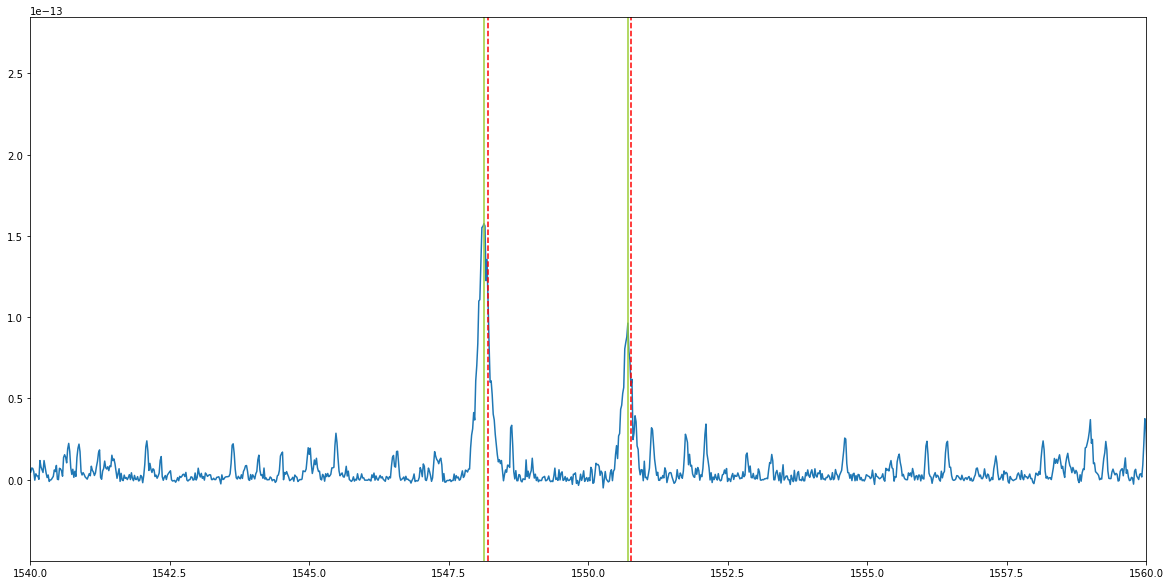

In [8]:
# ALL REST LINES

mask = w > 1220
fig, ax = plt.subplots()
ax.plot(w[mask], f[mask])
fig.set_figheight(10)
fig.set_figwidth(20) 

for line in df['Wavelength']:
    if(line > 1220):
        plt.axvline(x = line, color = 'red', label = 'axvline - full height', linestyle = "--")
    
for peak in w[mask][peaks]:
    plt.axvline(x = peak, color = 'yellowgreen', label = 'axvline - full height')
    
plt.xlim([1540, 1560])
    